In [1]:
# TODO: 家族の生存の相関
# https://www.mirandora.com/?p=1804

In [75]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from sklearn import ensemble
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [3]:
data = pd.read_csv('../data/train.csv')
df, df_test = train_test_split(data, test_size = 0.2, random_state = 1)

# SettingWithCopyWarning を抑制
# https://github.com/mmiyahara/docs/issues/6
df = df.copy()
df_test = df_test.copy()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
301,302,1,3,"McCoy, Mr. Bernard",male,NaN,2,0,367226,23.2500,NaN,Q
309,310,1,1,"Francatelli, Miss. Laura Mabel",female,30.0,0,0,PC 17485,56.9292,E36,C
516,517,1,2,"Lemore, Mrs. (Amelia Milley)",female,34.0,0,0,C.A. 34260,10.5000,F33,S
120,121,0,2,"Hickman, Mr. Stanley George",male,21.0,2,0,S.O.C. 14879,73.5000,NaN,S
570,571,1,2,"Harris, Mr. George",male,62.0,0,0,S.W./PP 752,10.5000,NaN,S


In [4]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            144
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          547
Embarked         2
dtype: int64

In [5]:
# 欠損値が多い Cabin を除外
df = df.drop('Cabin', axis=1)

In [6]:
# カテゴリデータを確認
df.nunique()

PassengerId    712
Survived         2
Pclass           3
Name           712
Sex              2
Age             86
SibSp            7
Parch            7
Ticket         569
Fare           228
Embarked         3
dtype: int64

`Pclass`、`Sex`、`SibSp`、`Parch`、`Embarked` はカテゴリデータっぽい。確認してみる。

In [7]:
df[['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']].head()

,Pclass,Sex,SibSp,Parch,Embarked
301,3,male,2,0,Q
309,1,female,0,0,C
516,2,female,0,0,S
120,2,male,2,0,S
570,2,male,0,0,S


In [8]:
# Sex, Embarked を数値データに変換する
df['Male'] = df['Sex'].map({'female': 0, 'male': 1})
df['Embarked'] = df['Embarked'].map({'C': 1, 'Q': 2, 'S': 3})
df[['Pclass', 'Male', 'SibSp', 'Parch', 'Embarked']].head()

,Pclass,Male,SibSp,Parch,Embarked
301,3,1,2,0,2.0
309,1,0,0,0,1.0
516,2,0,0,0,3.0
120,2,1,2,0,3.0
570,2,1,0,0,3.0


In [9]:
# Age の欠損が多いが、欠損データを除いた場合、
# Survived と他の項目の相関がどうなるか見てみる
df_dn = df.dropna()
df_dn = df_dn.drop('Name', axis=1)
df_dn = df_dn.drop('Ticket', axis=1)
df_dn = df_dn.drop('PassengerId', axis=1)

df_dn.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Male        0
dtype: int64

<AxesSubplot:>

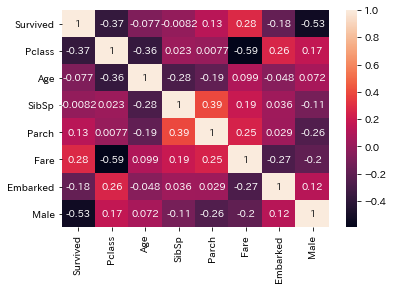

In [10]:
sns.heatmap(df_dn.corr(), annot=True)

`Male`、`Pclass`、`Fare` あたりの相関が大きい。  
年齢の相関は高くないが、子どもや高齢者の生存率は高そう。調べてみる。

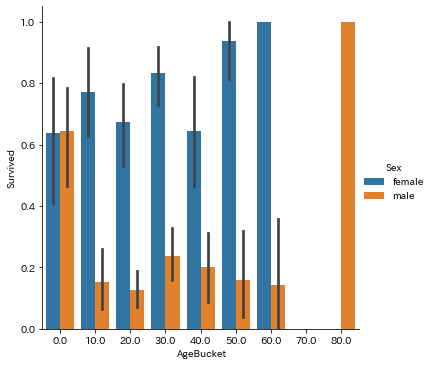

In [11]:
# 年齢バケツを算出する関数
def getBucketAge(row):
    age = row['Age']
    return (age // 10) * 10

df_dn['AgeBucket'] = df_dn.apply(getBucketAge, axis=1)
g = sns.catplot(x="AgeBucket", y="Survived", hue="Sex", data=df_dn, kind="bar")

0-10 歳、80-90 歳の生存率が高い。予測に使えそうなので、敬称から年齢の欠損値を補完しておく。

In [12]:
# 敬称を抽出する関数
def getTitle(row):
    name = row['Name']
    p = re.compile('.*\ (.*)\.\ .*')
    surname = p.search(name)
    return surname.group(1)

df['Title'] = df.apply(getTitle, axis=1)
df[['Name', 'Title']]

,Name,Title
301,"McCoy, Mr. Bernard",Mr
309,"Francatelli, Miss. Laura Mabel",Miss
516,"Lemore, Mrs. (Amelia Milley)",Mrs
120,"Hickman, Mr. Stanley George",Mr
570,"Harris, Mr. George",Mr
...,...,...
715,"Soholt, Mr. Peter Andreas Lauritz Andersen",Mr
767,"Mangan, Miss. Mary",Miss
72,"Hood, Mr. Ambrose Jr",Mr
235,"Harknett, Miss. Alice Phoebe",Miss


In [13]:
# 敬称ごとの年齢の中央値を求める
title_ages = df.groupby('Title').median()['Age']
title_ages

Title
Capt        70.0
Col         58.0
Countess    33.0
Don         40.0
Dr          44.0
L           54.0
Lady        48.0
Major       48.5
Master       3.5
Miss        22.0
Mlle        24.0
Mme         24.0
Mr          30.0
Mrs         36.0
Rev         51.0
Name: Age, dtype: float64

In [14]:
# 敬称ごとの年齢の中央値を取得する
def getAgeByTitle(title):
    return title_ages[title]

# Age の欠損値を敬称ごとの中央値で補完する
def fillNaByTitle(row):
    if pd.isna(row['Age']):
        return getAgeByTitle(row['Title'])
    else:
        return row['Age']
    
df['Age'] = df.apply(fillNaByTitle, axis=1)
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       2
Male           0
Title          0
dtype: int64

In [15]:
# 欠損値を含む行を削除
df = df.dropna()
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Male           0
Title          0
dtype: int64

In [16]:
# モデルに不要なデータを削除 (決定木に string を渡すとエラーになる)
df = df.drop('PassengerId', axis=1)
df = df.drop('Name', axis=1)
df = df.drop('Sex', axis=1)
df = df.drop('Ticket', axis=1)
df = df.drop('Title', axis=1)

## 決定木でモデル作成

In [33]:
X_train = df.drop('Survived', axis=1)
y_train = df.iloc[:, 0]

In [18]:
# テストデータに、訓練データと同じ加工を行う
df_test['Male'] = df_test['Sex'].map({'female': 0, 'male': 1})
df_test['Embarked'] = df_test['Embarked'].map({'C': 1, 'Q': 2, 'S': 3})
df_test['Title'] = df_test.apply(getTitle, axis=1)

In [19]:
# 敬称ごとの年齢の中央値を取得する
def getAgeByTitleTest(title):
    return df_test.groupby('Title').median()['Age'][title]

# Age の欠損値を敬称ごとの中央値で補完する
def fillNaByTitleTest(row):
    if pd.isna(row['Age']):
        return getAgeByTitleTest(row['Title'])
    else:
        return row['Age']
    
df_test['Age'] = df_test.apply(fillNaByTitleTest, axis=1)
df_test = df_test.drop('PassengerId', axis=1)
df_test = df_test.drop('Name', axis=1)
df_test = df_test.drop('Title', axis=1)
df_test = df_test.drop('Sex', axis=1)
df_test = df_test.drop('Ticket', axis=1)
df_test = df_test.drop('Cabin', axis=1)
df_test = df_test.dropna()

X_test = df_test.drop('Survived', axis=1)
y_test = df_test.iloc[:, 0]

Text(0.5, 0.98, 'Accuracy per each depth')

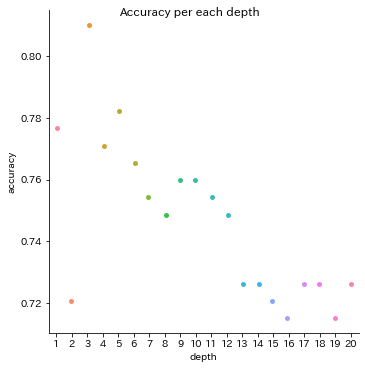

In [20]:
accuracies = []
r2_scores = []
dec_max_acc_depth = 0
dec_max_acc = 0
for i in range(20):
    clf = tree.DecisionTreeClassifier(max_depth=i+1)
    model = clf.fit(X_train, y_train)
    predicted = model.predict(X_test)
    dec_acc = accuracy_score(y_test, predicted)
    accuracies.append((i + 1, dec_acc)) 
    R2 = r2_score(y_test.to_list(), predicted)
    r2_scores.append((i + 1, R2))
    if dec_max_acc < dec_acc:
        dec_max_acc_depth = i + 1
        dec_max_acc = dec_acc
    
df_ac = pd.DataFrame(accuracies, columns=['depth', 'accuracy'])
g = sns.catplot(x='depth', y='accuracy', data=df_ac)
g.fig.suptitle('Accuracy per each depth')

In [22]:
print('Depth: {}, Accuracy: {}'.format(dec_max_acc_depth, dec_max_acc))

Depth: 3, Accuracy: 0.8100558659217877


`max_depth=3` で一番精度が良い。`0.810`。

## ランダムフォレストでモデル作成

Text(0.5, 0.98, 'Accuracy per each depth')

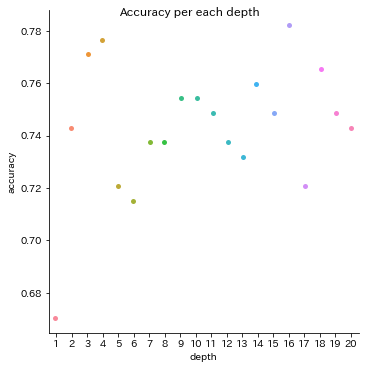

In [23]:
rf_accuracies = []
rf_r2_scores = []
for i in range(20):
    rf_clf = ensemble.RandomForestClassifier(n_estimators=i+1)
    rf_model = rf_clf.fit(X_train, y_train)
    rf_predicted = rf_model.predict(X_test)
    rf_accuracies.append((i + 1, accuracy_score(y_test, rf_predicted))) 
    rf_R2 = r2_score(y_test.to_list(), rf_predicted)
    rf_r2_scores.append((i + 1, rf_R2))

rf_max_acc_depth = 0
rf_max_acc = 0
for each_acc in rf_accuracies:
    depth, acc = each_acc
    if acc > rf_max_acc:
        rf_max_acc_depth = depth
        rf_max_acc = acc

df_rf_ac = pd.DataFrame(rf_accuracies, columns=['depth', 'accuracy'])
g = sns.catplot(x='depth', y='accuracy', data=df_rf_ac)
g.fig.suptitle('Accuracy per each depth')

Text(0.5, 0.98, 'Score per each depth')

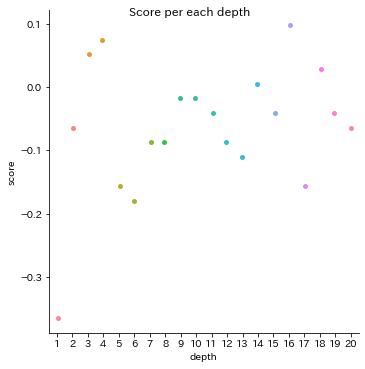

In [24]:
df_rf_r2 = pd.DataFrame(rf_r2_scores, columns=['depth', 'score'])
g = sns.catplot(x='depth', y='score', data=df_rf_r2)
g.fig.suptitle('Score per each depth')

In [25]:
print('Depth: {}, Accuracy: {}'.format(rf_max_acc_depth, rf_max_acc))

Depth: 16, Accuracy: 0.7821229050279329


<AxesSubplot:xlabel='importances', ylabel='features'>

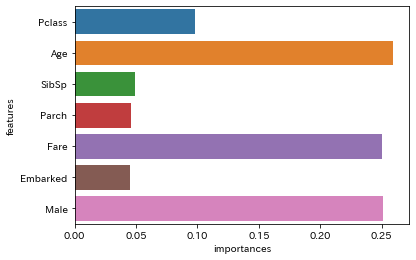

In [26]:
# 特徴量を算出
rf_clf_13 = ensemble.RandomForestClassifier(n_estimators=rf_max_acc_depth)
rf_model_13 = rf_clf.fit(X_train, y_train)
feature_importances = pd.DataFrame([X_train.columns, rf_model_13.feature_importances_]).T
feature_importances.columns = ['features', 'importances']
sns.barplot(
    x=feature_importances['importances'],
    y=feature_importances['features'],
    data=feature_importances
)

`Fare`、`Age`、`Male` が分類に効果的だったっぽい。

## LightGBMでモデル作成

In [110]:
lgb_accuracies = []
RMSEs = []
gbm_max_acc_depth = 0
gbm_max_acc = 0
for i in range(20):
    gbm = lgb.LGBMClassifier(
        objective='binary',
        max_depth= i + 1,
    )
    gbm.fit(
        X_train,
        y_train,
        eval_set = [(X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False,
    )
    lgb_predicted = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
    gbm_acc = accuracy_score(y_test, lgb_predicted)
    RMSE = np.sqrt(mean_squared_error(lgb_predicted, y_test))
    RMSEs.append((i + 1, RMSE))
    if gbm_max_acc < gbm_acc:
        gbm_max_acc_depth = i + 1
        gbm_max_acc = gbm_acc

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

In [111]:
print('Depth: {}, Accuracy: {}'.format(gbm_max_acc_depth, gbm_max_acc))

Depth: 3, Accuracy: 0.7877094972067039


In [109]:
print('Accuracy: {}'.format(gbm_max_acc_depth, gbm_max_acc))

Accuracy: 1


In [103]:
# カテゴリーデータを指定して再実施
categorical_features=['Pclass', 'Parch', 'Embarked', 'Male']
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train, categorical_feature=categorical_features)

params = {
    'objective': 'binary'
}

model = lgb.train(params, lgb_train,
                  valid_sets=[lgb_train, lgb_eval],
                  verbose_eval=10,
                  num_boost_round=1000,
                  early_stopping_rounds=10)

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

[LightGBM] [Info] Number of positive: 267, number of negative: 443
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 203
[LightGBM] [Info] Number of data points in the train set: 710, number of used features: 7


/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376056 -> initscore=-0.506321
[LightGBM] [Info] Start training from score -0.506321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	training's binary_logloss: 0.411919	valid_1's bina

In [80]:
y_pred[:10]

array([0.84103773, 0.09638494, 0.87008054, 0.755779  , 0.8750722 ,
       0.12194574, 0.0634451 , 0.96272822, 0.37670231, 0.64108337])

In [84]:
y_pred = (y_pred > 0.5).astype(int)
accuracy_score(y_test, y_pred)

0.7821229050279329

In [92]:
# パフォーマンスチューニング
import optuna
from sklearn.metrics import log_loss

def objective(trial):
    params = {
        'objective': 'binary',
        'verbose': -1,
        'max_bin': trial.suggest_int('max_bin', 255, 500),
        'learning_rate': 0.05,
        'num_leaves': trial.suggest_int('num_leaves', 32, 128),
    }

    lgb_train = lgb.Dataset(X_train, y_train,
                            categorical_feature=categorical_features)
    lgb_eval = lgb.Dataset(X_test, y_test,
                           reference=lgb_train,
                           categorical_feature=categorical_features)

    model = lgb.train(params, lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=1000,
                      early_stopping_rounds=10)

    y_pred_valid = model.predict(X_test, num_iteration=model.best_iteration)
    score = log_loss(y_test, y_pred_valid)
    return score

In [95]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=40)

[I 2021-04-20 00:04:49,490] A new study created in memory with name: no-name-018c127e-bd83-48c2-bc33-9907ffde008f
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
[I 2021-04-20 00:04:49,694] Trial 0 finished with value: 0.47724023356704565 and parameters: {'max_bin': 390, 'num_leaves': 101}. Best is trial 0 with value: 0.47724023356704565.
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: 

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.494743	valid_1's binary_logloss: 0.557074
[20]	training's binary_logloss: 0.415693	valid_1's binary_logloss: 0.511373
[30]	training's binary_logloss: 0.365135	valid_1's binary_logloss: 0.485715
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
[50]	training's binary_logloss: 0.309433	valid_1's binary_logloss: 0.480312
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724


/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.494743	valid_1's binary_logloss: 0.557074
[20]	training's binary_logloss: 0.415693	valid_1's binary_logloss: 0.511373
[30]	training's binary_logloss: 0.365135	valid_1's binary_logloss: 0.485715
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724


[I 2021-04-20 00:04:49,977] Trial 1 finished with value: 0.47724023356704565 and parameters: {'max_bin': 403, 'num_leaves': 84}. Best is trial 0 with value: 0.47724023356704565.


[50]	training's binary_logloss: 0.309433	valid_1's binary_logloss: 0.480312
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.494743	valid_1's binary_logloss: 0.557074
[20]	training's binary_logloss: 0.415693	valid_1's binary_logloss: 0.511373
[30]	training's binary_logloss: 0.365135	valid_1's binary_logloss: 0.485715
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724


/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
[I 2021-04-20 00:04:50,190] Trial 2 finished with value: 0.47724023356704565 and parameters: {'max_bin': 359, 'num_leaves': 94}. Best is trial 0 with value: 0.47724023356704565.
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/a

[50]	training's binary_logloss: 0.309433	valid_1's binary_logloss: 0.480312
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.494743	valid_1's binary_logloss: 0.557074
[20]	training's binary_logloss: 0.415693	valid_1's binary_logloss: 0.511373
[30]	training's binary_logloss: 0.365135	valid_1's binary_logloss: 0.485715
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
[50]	training's binary_logloss: 0.309433	valid_1's binary_logloss: 0.480312
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.494743	valid_1's binary_logloss: 0.557074
[20]	training's binary_logloss: 0.415693	valid_1's binary_logloss: 0.511373
[30]	training's binary_logloss: 0.365135	valid_1's 

/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
[I 2021-04-20 00:04:50,399] Trial 4 finished with value: 0.47724023356704565 and parameters: {'max_bin': 492, 'num_leaves': 69}. Best is trial 0 with value: 0.47724023356704565.
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/a

[50]	training's binary_logloss: 0.309433	valid_1's binary_logloss: 0.480312
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.494743	valid_1's binary_logloss: 0.557074
[20]	training's binary_logloss: 0.415693	valid_1's binary_logloss: 0.511373
[30]	training's binary_logloss: 0.365135	valid_1's binary_logloss: 0.485715
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
[50]	training's binary_logloss: 0.309433	valid_1's binary_logloss: 0.480312
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.494743	valid_1's binary_logloss: 0.557074
[20]	training's binary_logloss: 0.415693	valid_1's binary_logloss: 0.511373
[30]	training's binary_logloss: 0.365135	valid_1's 

/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
[I 2021-04-20 00:04:50,641] Trial 7 finished with value: 0.47724023356704565 and parameters: {'max_bin': 272, 'num_leaves': 40}. Best is trial 0 with value: 0.47724023356704565.
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/a

[10]	training's binary_logloss: 0.494743	valid_1's binary_logloss: 0.557074
[20]	training's binary_logloss: 0.415693	valid_1's binary_logloss: 0.511373
[30]	training's binary_logloss: 0.365135	valid_1's binary_logloss: 0.485715
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
[50]	training's binary_logloss: 0.309433	valid_1's binary_logloss: 0.480312
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.494743	valid_1's binary_logloss: 0.557074
[20]	training's binary_logloss: 0.415693	valid_1's binary_logloss: 0.511373
[30]	training's binary_logloss: 0.365135	valid_1's binary_logloss: 0.485715
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
[50]	training's binary_logloss: 0.309433	valid_1's binary_logloss: 0.480312
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.33

[I 2021-04-20 00:04:50,805] Trial 10 finished with value: 0.47724023356704565 and parameters: {'max_bin': 495, 'num_leaves': 109}. Best is trial 0 with value: 0.47724023356704565.
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
[I 2021-04-20 00:04:50,874] Trial 11 finished with value: 0.47724023356704565 and parameters: {'max_bin': 368, 'num_leaves': 107}. Best is trial 0 with value: 0.47724023356704565.
/Users/m000732/opt/anaconda

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.494743	valid_1's binary_logloss: 0.557074
[20]	training's binary_logloss: 0.415693	valid_1's binary_logloss: 0.511373
[30]	training's binary_logloss: 0.365135	valid_1's binary_logloss: 0.485715
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
[50]	training's binary_logloss: 0.309433	valid_1's binary_logloss: 0.480312
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.494743	valid_1's binary_logloss: 0.557074
[20]	training's binary_logloss: 0.415693	valid_1's binary_logloss: 0.511373
[30]	training's binary_logloss: 0.365135	valid_1's binary_logloss: 0.485715
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
[50]	training's binary_logloss: 0.309433	valid_1's binary_logloss: 0.480312
Early stop

[I 2021-04-20 00:04:51,030] Trial 13 finished with value: 0.47724023356704565 and parameters: {'max_bin': 290, 'num_leaves': 123}. Best is trial 0 with value: 0.47724023356704565.
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
[I 2021-04-20 00:04:51,131] Trial 14 finished with value: 0.47724023356704565 and parameters: {'max_bin': 383, 'num_leaves': 72}. Best is trial 0 with value: 0.47724023356704565.
/Users/m000732/opt/anaconda3

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.494743	valid_1's binary_logloss: 0.557074
[20]	training's binary_logloss: 0.415693	valid_1's binary_logloss: 0.511373
[30]	training's binary_logloss: 0.365135	valid_1's binary_logloss: 0.485715
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
[50]	training's binary_logloss: 0.309433	valid_1's binary_logloss: 0.480312
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.494743	valid_1's binary_logloss: 0.557074
[20]	training's binary_logloss: 0.415693	valid_1's binary_logloss: 0.511373
[30]	training's binary_logloss: 0.365135	valid_1's binary_logloss: 0.485715
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
[50]	training's binary_logloss: 0.309433	valid_1's binary_logloss: 0.480312
Early stop

[I 2021-04-20 00:04:51,259] Trial 16 finished with value: 0.47724023356704565 and parameters: {'max_bin': 367, 'num_leaves': 87}. Best is trial 0 with value: 0.47724023356704565.
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
[I 2021-04-20 00:04:51,314] Trial 17 finished with value: 0.47724023356704565 and parameters: {'max_bin': 259, 'num_leaves': 91}. Best is trial 0 with value: 0.47724023356704565.
/Users/m000732/opt/anaconda3/

[50]	training's binary_logloss: 0.309433	valid_1's binary_logloss: 0.480312
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.494743	valid_1's binary_logloss: 0.557074
[20]	training's binary_logloss: 0.415693	valid_1's binary_logloss: 0.511373
[30]	training's binary_logloss: 0.365135	valid_1's binary_logloss: 0.485715
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
[50]	training's binary_logloss: 0.309433	valid_1's binary_logloss: 0.480312
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.494743	valid_1's binary_logloss: 0.557074
[20]	training's binary_logloss: 0.415693	valid_1's binary_logloss: 0.511373
[30]	training's binary_logloss: 0.365135	valid_1's 

/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
[I 2021-04-20 00:04:51,504] Trial 20 finished with value: 0.47724023356704565 and parameters: {'max_bin': 343, 'num_leaves': 74}. Best is trial 0 with value: 0.47724023356704565.
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/

[20]	training's binary_logloss: 0.415693	valid_1's binary_logloss: 0.511373
[30]	training's binary_logloss: 0.365135	valid_1's binary_logloss: 0.485715
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
[50]	training's binary_logloss: 0.309433	valid_1's binary_logloss: 0.480312
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.494743	valid_1's binary_logloss: 0.557074
[20]	training's binary_logloss: 0.415693	valid_1's binary_logloss: 0.511373
[30]	training's binary_logloss: 0.365135	valid_1's binary_logloss: 0.485715
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
[50]	training's binary_logloss: 0.309433	valid_1's binary_logloss: 0.480312
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
Training until validation scores don'

/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
[I 2021-04-20 00:04:51,764] Trial 24 finished with value: 0.47724023356704565 and parameters: {'max_bin': 332, 'num_leaves': 67}. Best is trial 0 with value: 0.47724023356704565.
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.494743	valid_1's binary_logloss: 0.557074
[20]	training's binary_logloss: 0.415693	valid_1's binary_logloss: 0.511373
[30]	training's binary_logloss: 0.365135	valid_1's binary_logloss: 0.485715
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
[50]	training's binary_logloss: 0.309433	valid_1's binary_logloss: 0.480312
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.494743	valid_1's binary_logloss: 0.557074
[20]	training's binary_logloss: 0.415693	valid_1's binary_logloss: 0.511373
[30]	training's binary_logloss: 0.365135	valid_1's binary_logloss: 0.485715
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
[50]	training's binary_logloss: 0.309433	valid_1's binary_logloss: 0.480312
Early stop

[I 2021-04-20 00:04:51,970] Trial 27 finished with value: 0.47724023356704565 and parameters: {'max_bin': 306, 'num_leaves': 47}. Best is trial 0 with value: 0.47724023356704565.
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
[I 2021-04-20 00:04:52,066] Trial 28 finished with value: 0.47724023356704565 and parameters: {'max_bin': 415, 'num_leaves': 56}. Best is trial 0 with value: 0.47724023356704565.
/Users/m000732/opt/anaconda3/

[10]	training's binary_logloss: 0.494743	valid_1's binary_logloss: 0.557074
[20]	training's binary_logloss: 0.415693	valid_1's binary_logloss: 0.511373
[30]	training's binary_logloss: 0.365135	valid_1's binary_logloss: 0.485715
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
[50]	training's binary_logloss: 0.309433	valid_1's binary_logloss: 0.480312
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.494743	valid_1's binary_logloss: 0.557074
[20]	training's binary_logloss: 0.415693	valid_1's binary_logloss: 0.511373
[30]	training's binary_logloss: 0.365135	valid_1's binary_logloss: 0.485715
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
[50]	training's binary_logloss: 0.309433	valid_1's binary_logloss: 0.480312
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.33

[I 2021-04-20 00:04:52,141] Trial 29 finished with value: 0.47724023356704565 and parameters: {'max_bin': 369, 'num_leaves': 55}. Best is trial 0 with value: 0.47724023356704565.
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
[I 2021-04-20 00:04:52,214] Trial 30 finished with value: 0.47724023356704565 and parameters: {'max_bin': 294, 'num_leaves': 42}. Best is trial 0 with value: 0.47724023356704565.
/Users/m000732/opt/anaconda3/

[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
[50]	training's binary_logloss: 0.309433	valid_1's binary_logloss: 0.480312
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.494743	valid_1's binary_logloss: 0.557074
[20]	training's binary_logloss: 0.415693	valid_1's binary_logloss: 0.511373
[30]	training's binary_logloss: 0.365135	valid_1's binary_logloss: 0.485715
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
[50]	training's binary_logloss: 0.309433	valid_1's binary_logloss: 0.480312
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.494743	valid_1's binary_logloss: 0.557074
[20]	training's binary_logloss: 0.415693	valid_1's b

/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
[I 2021-04-20 00:04:52,375] Trial 33 finished with value: 0.47724023356704565 and parameters: {'max_bin': 456, 'num_leaves': 41}. Best is trial 0 with value: 0.47724023356704565.
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/

[10]	training's binary_logloss: 0.494743	valid_1's binary_logloss: 0.557074
[20]	training's binary_logloss: 0.415693	valid_1's binary_logloss: 0.511373
[30]	training's binary_logloss: 0.365135	valid_1's binary_logloss: 0.485715
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
[50]	training's binary_logloss: 0.309433	valid_1's binary_logloss: 0.480312
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.494743	valid_1's binary_logloss: 0.557074
[20]	training's binary_logloss: 0.415693	valid_1's binary_logloss: 0.511373
[30]	training's binary_logloss: 0.365135	valid_1's binary_logloss: 0.485715
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
[50]	training's binary_logloss: 0.309433	valid_1's binary_logloss: 0.480312
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.33

/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
[I 2021-04-20 00:04:52,586] Trial 36 finished with value: 0.47724023356704565 and parameters: {'max_bin': 495, 'num_leaves': 90}. Best is trial 0 with value: 0.47724023356704565.
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/

[10]	training's binary_logloss: 0.494743	valid_1's binary_logloss: 0.557074
[20]	training's binary_logloss: 0.415693	valid_1's binary_logloss: 0.511373
[30]	training's binary_logloss: 0.365135	valid_1's binary_logloss: 0.485715
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
[50]	training's binary_logloss: 0.309433	valid_1's binary_logloss: 0.480312
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.494743	valid_1's binary_logloss: 0.557074
[20]	training's binary_logloss: 0.415693	valid_1's binary_logloss: 0.511373
[30]	training's binary_logloss: 0.365135	valid_1's binary_logloss: 0.485715
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
[50]	training's binary_logloss: 0.309433	valid_1's binary_logloss: 0.480312
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.33

[I 2021-04-20 00:04:52,777] Trial 39 finished with value: 0.47724023356704565 and parameters: {'max_bin': 327, 'num_leaves': 43}. Best is trial 0 with value: 0.47724023356704565.


[30]	training's binary_logloss: 0.365135	valid_1's binary_logloss: 0.485715
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724
[50]	training's binary_logloss: 0.309433	valid_1's binary_logloss: 0.480312
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.332246	valid_1's binary_logloss: 0.47724


In [94]:
study.best_params

{'max_bin': 390, 'num_leaves': 101}

In [97]:
params = {
    'objective': 'binary',
    'max_bin': 390,
    'learning_rate': 0.05,
    'num_leaves': 101
}


lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(X_test, y_test,reference=lgb_train,categorical_feature=categorical_features)

model = lgb.train(params, lgb_train,
                  valid_sets=[lgb_train, lgb_eval],
                  verbose_eval=10,
                  num_boost_round=1000,
                  early_stopping_rounds=10)

y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred = (y_pred > 0.5).astype(int)
accuracy_score(y_test, y_pred)

/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 267, number of negative: 443
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 203
[LightGBM] [Info] Number of data points in the train set: 710, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376056 -> initscore=-0.506321
[LightGBM] [Info] Start training from score -0.506321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

0.7821229050279329

In [113]:
lgb_accuracies = []
RMSEs = []
gbm_max_acc_depth = 0
gbm_max_acc = 0
for i in range(20):
    gbm = lgb.LGBMClassifier(
        objective='binary',
        max_depth= i + 1,
        max_bin=390,
        learning_rate=0.05,
        num_leaves=101
    )
    gbm.fit(
        X_train,
        y_train,
        eval_set = [(X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False,
    )
    lgb_predicted = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
    gbm_acc = accuracy_score(y_test, lgb_predicted)
    RMSE = np.sqrt(mean_squared_error(lgb_predicted, y_test))
    RMSEs.append((i + 1, RMSE))
    if gbm_max_acc < gbm_acc:
        gbm_max_acc_depth = i + 1
        gbm_max_acc = gbm_acc

In [114]:
print('Depth: {}, Accuracy: {}'.format(gbm_max_acc_depth, gbm_max_acc))

Depth: 2, Accuracy: 0.7877094972067039
